# 1. Instalação de dependências

In [17]:
!pip install -q scikit-learn pandas joblib

# 2. Imports e configurações iniciais

In [18]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score


import joblib

# 3. Função de limpeza de texto

In [39]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#", " ", text)
    text = re.sub(r"[^a-záéíóúüñ\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


# 4. Tratamento de Negações

In [41]:
def handle_negations(text):
    if not isinstance(text, str):
        return ""
    patterns = [
        r"\bno\s+(\w+)",
        r"\bnunca\s+(\w+)",
        r"\bjamas\s+(\w+)",
        r"\bjamás\s+(\w+)",  # com acento
        r"\btampoco\s+(\w+)"
    ]
    for p in patterns:
        text = re.sub(p, r"no_\1", text)
    return text


# 5. Tratamento de Intensificadores

In [42]:
def handle_intensifiers(text):
    if not isinstance(text, str):
        return ""

    intensifiers = r"(muy bien|muy|super|extremadamente|bastante|totalmente)"

    adjectives = (
        r"malo|mala|malos|malas|"
        r"terrible|horrible|pésimo|deficiente|regular|"
        r"insatisfecho|decepcionado|"
        r"bueno|buena|buenos|buenas|"
        r"genial|excelente|perfecto|increíble|confuso"
    )

    text = re.sub(
        rf"\b{intensifiers}\s+({adjectives})",
        r"\1_\2",
        text
    )

    return text



# 6. Pipeline único de pré-processamento

6.1 Colapsar intensificador + polaridade

In [43]:
def preprocess_text(text):
  text = clean_text(text)
  text = handle_negations(text)
  text = handle_intensifiers(text)
  return text


6.2 Colapso semântico de eventos negativos

In [45]:
# 6.2 Colapso semântico de eventos negativos
def handle_negative_events(text):
    """
    Junta substantivo + evento negativo.
    Ex:
    'entrega retrasada' -> 'entrega_retrasada'
    'caja aplastada'   -> 'caja_aplastada'
    'producto dañado' -> 'producto_dañado'
    """
    if not isinstance(text, str):
        return ""

    patterns = [
        # Entrega
        r"\b(entrega|envío)\s+(retrasado|retrasada|tardío|tardía)",

        # Produto / embalagem
        r"\b(caja|producto|paquete)\s+(abollado|abollada|roto|rota|dañado|dañada|aplastado|aplastada)",

        # Problemas gerais
        r"\b(problema|error|falla)\s+(persistente|grave|recurrente)"
    ]

    for p in patterns:
        text = re.sub(p, r"\1_\2", text)

    return text



# 7. Normalização de colunas (fallback)

In [46]:
def normalize_columns(df):
    rename_map = {
        # Texto
        'texto': 'text',
        'comentario': 'text',
        'comentarios': 'text',
        'opinion': 'text',
        'review': 'text',

        # Label
        'sentimiento': 'label',
        'clase': 'label',
        'etiqueta': 'label'
    }

    df = df.rename(columns={c: rename_map[c] for c in df.columns if c in rename_map})

    if 'text' not in df.columns or 'label' not in df.columns:
        raise ValueError("El archivo CSV debe contener columnas de texto y etiqueta.")

    return df[['text', 'label']]


# 8. Carregamento do dataset

In [47]:
from google.colab import files
import io


uploaded = files.upload()
filename = list(uploaded.keys())[0]


df = pd.read_csv(
    io.BytesIO(uploaded[filename]),
    sep=",",
    quotechar='"',
    doublequote=True,
    escapechar="\\",
    encoding="utf-8",
    engine="python",
  on_bad_lines="skip"
)


df = normalize_columns(df)
print("Número total de registros cargados:", len(df))
display(df.head())


Saving data-es.csv to data-es (1).csv
Número total de registros cargados: 3256


,text,label
0,"Excelente producto, llegó rápido y bien empaqu...",Positivo
1,"Llegó defectuoso, tuve que devolverlo. Terrible.",Negativo
2,"Entrega a tiempo, pero el embalaje llegó aplas...",Neutral
3,¡Me encantó! Color perfecto y material excelente.,Positivo
4,"Tardó 20 días en llegar, nunca más compro aquí.",Negativo


# 9. Limpeza e pré-processamento dos dados

In [48]:

df['text_clean'] = df['text'].apply(preprocess_text)
df = df[df['text_clean'] != ""]
df['label'] = df['label'].str.strip().str.capitalize()

print(df['label'].value_counts())



label
Negativo    1439
Positivo    1187
Neutral      630
Name: count, dtype: int64


# 10. Divisão treino / teste (ANTES do oversampling)

In [49]:
X = df['text_clean']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

# 11. Oversampling manual apenas no treino

In [50]:
# Oversampling manual apenas no conjunto de treino

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
majority_size = train_df['label'].value_counts().max()


balanced_parts = []
for label in train_df['label'].unique():
  subset = train_df[train_df['label'] == label]
  subset_upsampled = resample(
    subset,
    replace=True,
    n_samples=majority_size,
    random_state=42
  )
  balanced_parts.append(subset_upsampled)


train_balanced = pd.concat(balanced_parts).sample(frac=1, random_state=42)
print("Distribución después del sobremuestreo (entrenamiento):")
print(train_balanced['label'].value_counts())

Distribución después del sobremuestreo (entrenamiento):
label
Positivo    1151
Neutral     1151
Negativo    1151
Name: count, dtype: int64


# 12. Vetorização TF-IDF

In [51]:
tfidf = TfidfVectorizer(
  ngram_range=(1,2),
  min_df=2,
  max_df=0.9,
  sublinear_tf=True
)


X_train_tfidf = tfidf.fit_transform(train_balanced['text'])
X_test_tfidf = tfidf.transform(X_test)


y_train_bal = train_balanced['label']

# 13. Treinamento dos modelos

In [52]:
lr_model = LogisticRegression(
  max_iter=1000,
  class_weight='balanced',
  C=1.0,
  random_state=42
)


svm_model = LinearSVC(
  class_weight='balanced',
  random_state=42
)


lr_model.fit(X_train_tfidf, y_train_bal)
svm_model.fit(X_train_tfidf, y_train_bal)

LinearSVC(class_weight='balanced', random_state=42)

# 14. Avaliação (métricas confiáveis)

In [54]:
print('Precisión LR:', accuracy_score(y_test, y_pred_lr))
print('Precisión SVM:', accuracy_score(y_test, y_pred_svm))

print('\nInforme del modelo de regresión logística:\n')
print(classification_report(y_test, y_pred_lr, digits=4))

print('\nInforme del modelo SVM lineal:\n')
print(classification_report(y_test, y_pred_svm, digits=4))


Precisión LR: 0.9570552147239264
Precisión SVM: 0.9647239263803681

Informe del modelo de regresión logística:

              precision    recall  f1-score   support

    Negativo     0.9650    0.9583    0.9617       288
     Neutral     0.9380    0.9603    0.9490       126
    Positivo     0.9578    0.9538    0.9558       238

    accuracy                         0.9571       652
   macro avg     0.9536    0.9575    0.9555       652
weighted avg     0.9572    0.9571    0.9571       652


Informe del modelo SVM lineal:

              precision    recall  f1-score   support

    Negativo     0.9752    0.9549    0.9649       288
     Neutral     0.9535    0.9762    0.9647       126
    Positivo     0.9585    0.9706    0.9645       238

    accuracy                         0.9647       652
   macro avg     0.9624    0.9672    0.9647       652
weighted avg     0.9649    0.9647    0.9647       652



# 15. Matrizes de confusão

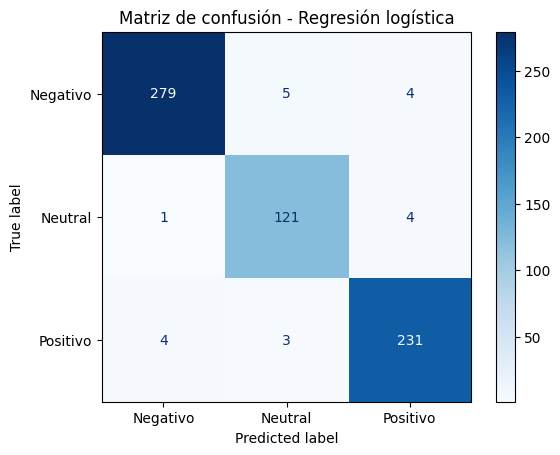

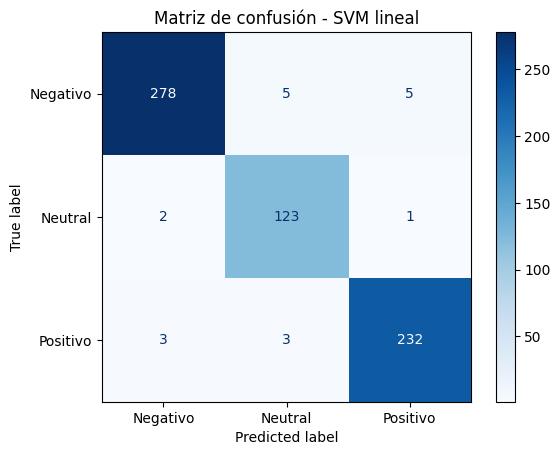

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== Matriz de Confusão - Logistic Regression =====
cm_lr = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=lr_model.classes_
)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=lr_model.classes_
)

disp_lr.plot(cmap='Blues')
plt.title('Matriz de confusión - Regresión logística')
plt.grid(False)
plt.show()


# ===== Matriz de Confusão - SVM Linear =====
cm_svm = confusion_matrix(
    y_test,
    y_pred_svm,
    labels=svm_model.classes_
)

disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=svm_model.classes_
)

disp_svm.plot(cmap='Blues')
plt.title('Matriz de confusión - SVM lineal')
plt.grid(False)
plt.show()


# 16. Comparação gráfica: LR vs SVM

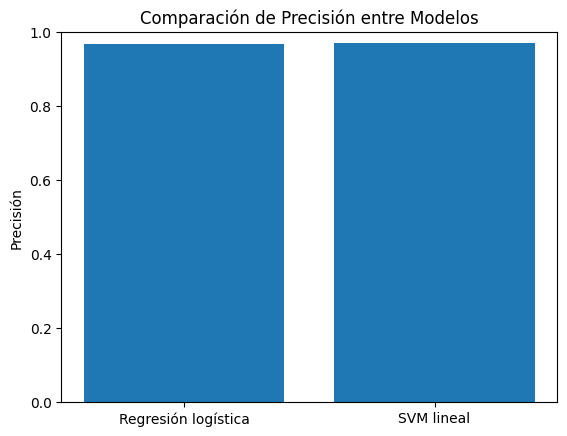

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Predições (garantia contra erro de execução fora de ordem)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Cálculo das acurácias
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)

# Dados para o gráfico
models = ['Regresión logística', 'SVM lineal']
accuracy_scores = [acc_lr, acc_svm]

# Gráfico de barras
plt.figure()
plt.bar(models, accuracy_scores)
plt.ylabel('Precisión')
plt.title('Comparación de Precisión entre Modelos')
plt.ylim(0, 1)  # padrão para métricas de classificação
plt.show()



# 17. Validação Cruzada Estratificada

In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


lr_cv_scores = cross_val_score(
  lr_model,
  X_train_tfidf,
  y_train_bal,
  cv=skf,
  scoring='f1_macro'
)


svm_cv_scores = cross_val_score(
  svm_model,
  X_train_tfidf,
  y_train_bal,
  cv=skf,
  scoring='f1_macro'
)


print('LR - Promedio F1:', lr_cv_scores.mean())
print('SVM - Promedio F1:', svm_cv_scores.mean())

LR - Promedio F1: 0.9829030927898292
SVM - Promedio F1: 0.990145679753659


# 18. Teste prático – frases novas

In [55]:
frases_teste = [
    "Muy insatisfecho con el servicio. No resolvieron mi problema.",
    "No me gustó. El color es muy diferente al de la foto del anuncio.",
    "El producto es honesto, cumple lo que promete sin lujos.",
    "La entrega se retrasó demasiado y la caja llegó aplastada.",
    "¡Simplemente fantástico, superó todas mis expectativas!",
    "Llegó roto, quiero que me devuelvan el dinero inmediatamente."
]

# Preprocesamiento
frases_proc = [preprocess_text(f) for f in frases_teste]
frases_vec = tfidf.transform(frases_proc)

# Predicciones
predicciones = lr_model.predict(frases_vec)
probabilidades = lr_model.predict_proba(frases_vec)

# Resultados
pd.DataFrame({
    'Texto': frases_teste,
    'Predicción': predicciones,
    'Confianza': probabilidades.max(axis=1).round(3)
})


,Texto,Predicción,Confianza
0,Muy insatisfecho con el servicio. No resolvier...,Negativo,0.516
1,No me gustó. El color es muy diferente al de l...,Negativo,0.581
2,"El producto es honesto, cumple lo que promete ...",Neutral,0.904
3,La entrega se retrasó demasiado y la caja lleg...,Negativo,0.866
4,"¡Simplemente fantástico, superó todas mis expe...",Positivo,0.743
5,"Llegó roto, quiero que me devuelvan el dinero ...",Negativo,0.834


# 19. Salvando modelos

In [57]:
import os
import joblib

# Criar pasta 'models' se não existir
os.makedirs('models', exist_ok=True)

# Salvar os modelos e o vetor TF-IDF
joblib.dump(lr_model, 'models/modelo_lr_sentimentos_es.pkl')
joblib.dump(svm_model, 'models/modelo_svm_sentimentos_es.pkl')
joblib.dump(tfidf, 'models/tfidf_es.pkl')

print("Todo está listo para probar los modelos guardados. ✅")

Todo está listo para probar los modelos guardados. ✅
